Yiting Wang 4646909520

(a)

In [16]:
import numpy as np, pandas as pd 
data = pd.read_table('../Data/communities.data', sep=',', header = None) 
features = pd.read_table('../Data/communities_features.txt', sep=',', header = None)       #features: the columns of data
data.columns = features[0]

(b)

In [17]:
#Convert string "?" into nan
data = data.replace('?', np.nan)

#I find the first five features are nonpredictive.
#Delete nonpredictive features
data = data.drop(columns = ['state', 'county', 'community', 'communityname', 'fold']).astype(float)

data_mean = data.mean()                    # Find the mean of columns
data = data.fillna(data_mean)              # Fill NAN with mean

#Construct train data and test data
train_data = data[:1495]
test_data = data[1495:]

(c)

In [18]:
#Plot the correlation matrix
correlation_matrix = data.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

(d)

In [27]:
#Construct CV
CV = pd.DataFrame(np.zeros((1,123)))
CV.index = ['index']
CV.columns = data.columns

for col in data.columns:
    s = np.std(data[col])                #s is sample standard deviation
    m = np.mean(data[col])               #m is sample mean
    CV[col] = s/m                        #CV = s/m

CV = CV.sort_values(by = 'index', axis = 1, ascending = False)        #Sort CV from high to low
print(CV)

0      NumStreet  NumInShelters  NumIlleg  NumImmig  LemasPctOfficDrugUn  \
index   4.406597       3.484607  2.993446   2.89977             2.554625   

0      NumUnderPov  population  numbUrban  HousVacant  LandArea  ...  \
index     2.304392     2.20295   2.001242    1.958288  1.677611  ...   

0      agePct12t29  PctSpeakEnglOnly  PctHousOccup  LemasSwFTFieldPerPop  \
index      0.29062          0.288601      0.269579              0.251355   

0      PolicReqPerOffic  NumKindsDrugsSeiz  RacialMatchCommPol  \
index          0.229149           0.145919            0.131384   

0      LemasPctPolicOnPatr  PctPolicWhite  LemasSwFTFieldOps  
index             0.122301       0.121629           0.057112  

[1 rows x 123 columns]


(e)

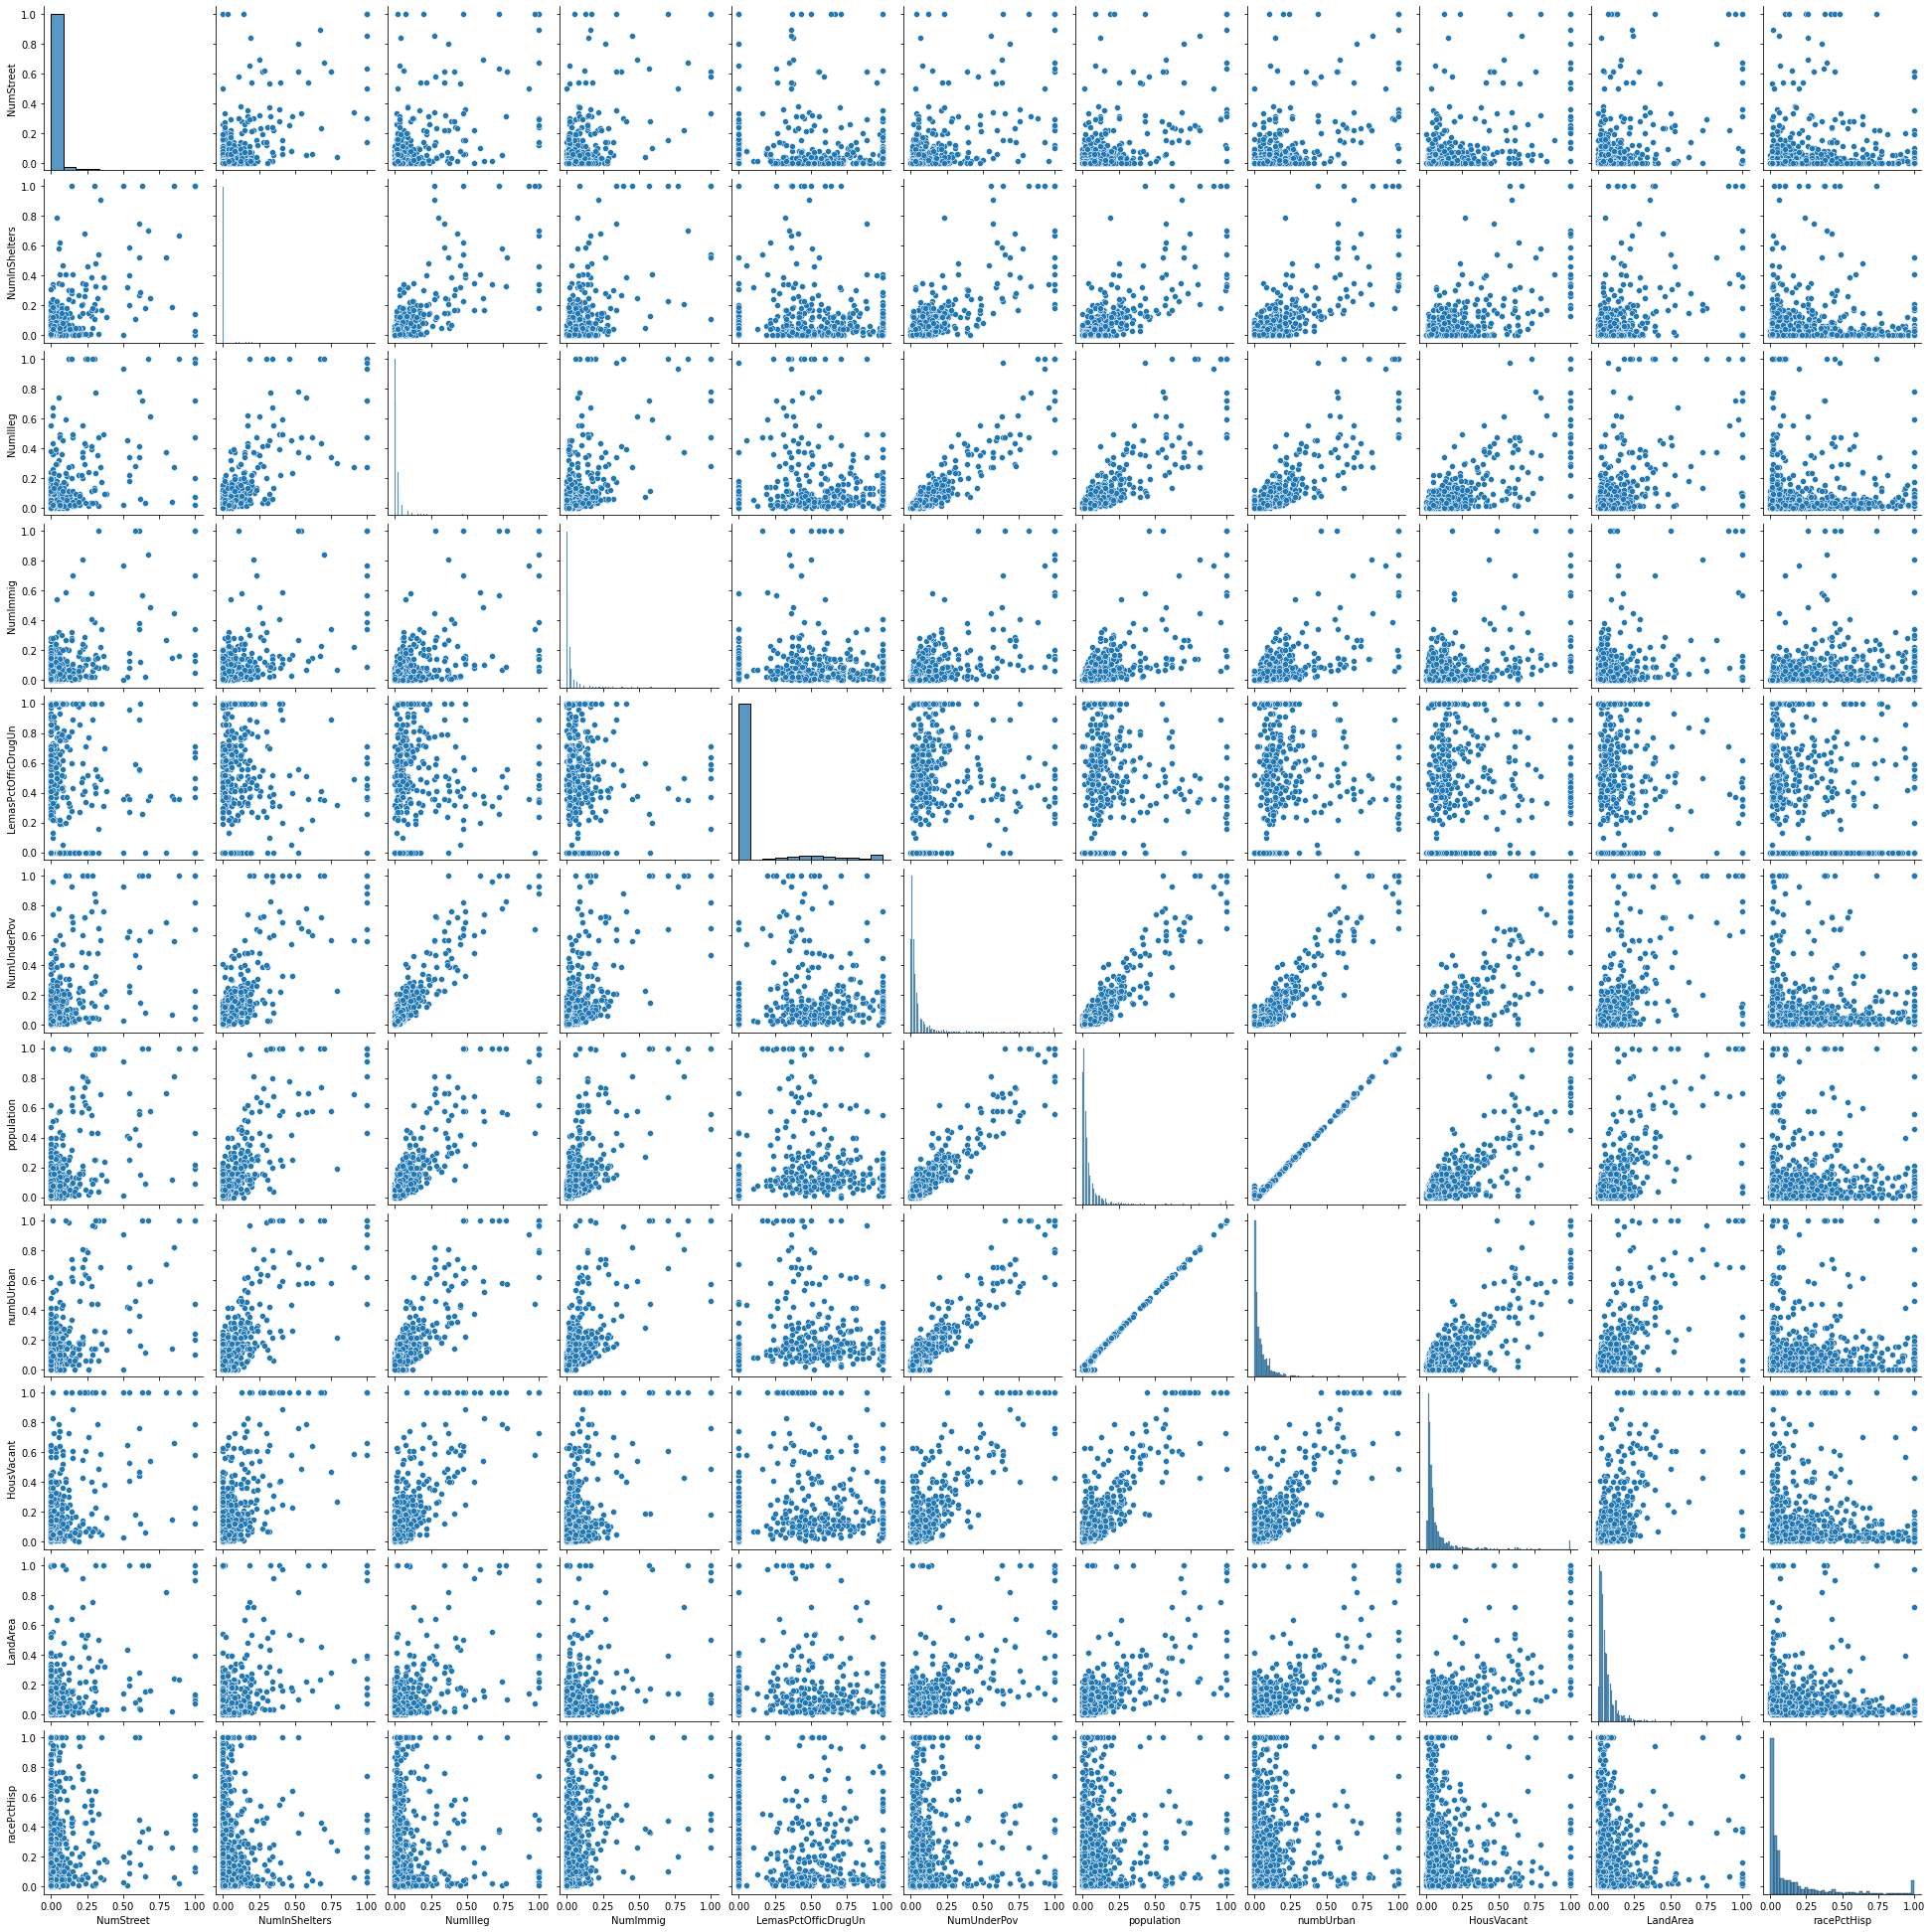

<AxesSubplot:>

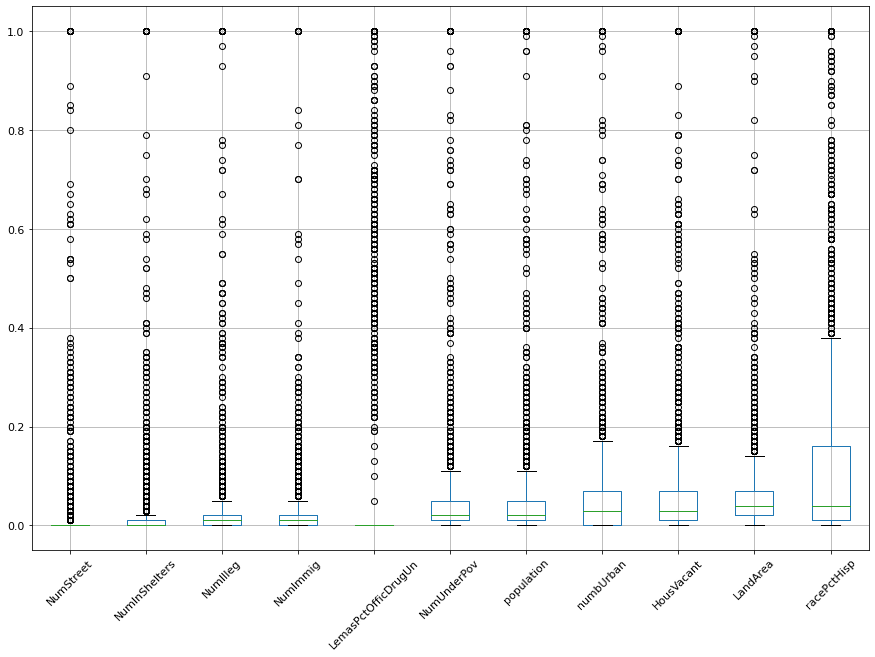

In [28]:
import math
CV_feature = CV.iloc[:, :math.floor(math.sqrt(128))].columns     #Pick sprt(128) features with highest CV
data_plot = data[CV_feature]                                     #Construct the data for plotting

#Scatter plots
import seaborn as sb
import matplotlib.pyplot as plt
sb.pairplot(data_plot)
plt.show()

#Box plots
data_plot.boxplot(rot=45, fontsize=11, figsize=(15, 10))

According to the scatter plots, I cannot tell the significance of those features. We can only know the positive and negative relationships between these features, like NumInShelters and Numllleg have positive relationships with many features.

(f)

In [30]:
#Construct X, y, X_train, y_train, X_test, y_test
X = data.drop(columns = ['ViolentCrimesPerPop']).astype(float)
y = data['ViolentCrimesPerPop']

X_train = train_data.drop(columns = ['ViolentCrimesPerPop']).astype(float)
y_train = train_data['ViolentCrimesPerPop']
X_test = test_data.drop(columns = ['ViolentCrimesPerPop']).astype(float)
y_test = test_data['ViolentCrimesPerPop']

In [31]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression().fit(X_train, y_train)

#Calculate the test error
test_error = 1 - linear.score(X_test, y_test)
test_error = round(test_error, 3)
print('Test Error For Linear Regression:',test_error)

Test Error For Linear Regression: 16.606


(g)

In [32]:
from sklearn.linear_model import Ridge, RidgeCV

#Find the best alpha
alphas_list = 10**np.linspace(10,-2,100)*0.5
ridge_CV = RidgeCV(alphas = alphas_list, cv = 10).fit(X_train, y_train) 
best_alpha = round(ridge_CV.alpha_, 3)
print('Best Alpha For Ridge Regression:', best_alpha)

#Construct the new ridge model
ridge = Ridge(alpha = best_alpha).fit(X_train, y_train) 

#Calculate the test error with best alpha
test_error = 1 - ridge.score(X_test, y_test)
test_error = round(test_error, 3)
print('Test Error For Ridge Regression:',test_error)

Best Alpha For Ridge Regression: 2.321
Test Error For Ridge Regression: 0.37


In [33]:
from sklearn.linear_model import Lasso, LassoCV

#Find the best alpha
alphas_list = 10**np.linspace(10,-2,100)*0.5
Lasso_CV = LassoCV(alphas = alphas_list, cv = 10).fit(X_train, y_train) 
best_alpha = round(Lasso_CV.alpha_, 3)
print('Best Alpha For LASSO Regression:', best_alpha)

#Construct the new LASSO model
Lasso = Lasso(alpha = best_alpha).fit(X_train, y_train) 

#Calculate the test error with best alpha
test_error = 1 - Lasso.score(X_test, y_test)
test_error = round(test_error, 3)
print('Test Error For LASSO Regression:',test_error)

#Select features
select_features = []
Lasso_coef = Lasso.coef_

for i in range(len(Lasso_coef)):
    if Lasso_coef[i]!=0:
        select_features.append(X.columns[i])
print('Selected Variables:', select_features)

Best Alpha For LASSO Regression: 0.005
Test Error For LASSO Regression: 0.395
Selected Variables: ['racePctWhite', 'pctUrban', 'MalePctDivorce', 'PctKids2Par', 'PctIlleg', 'PctPersDenseHous', 'HousVacant', 'PctVacantBoarded']


In [35]:
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LassoCV

#Standardized the data
scaler = preprocessing.StandardScaler().fit(X)
scaler_X_train = scaler.transform(X_train)
scaler_X_test = scaler.transform(X_test)

#Find the best alpha
alphas_list = 10**np.linspace(10,-2,100)*0.5
scaler_Lasso_CV = LassoCV(alphas = alphas_list, cv = 10).fit(scaler_X_train, y_train) 
best_alpha = round(scaler_Lasso_CV.alpha_, 3)
print('Best Alpha For LASSO Regression:', best_alpha)

#Calculate the test error with best alpha
scaler_Lasso = Lasso(alpha = best_alpha).fit(scaler_X_train, y_train) 
test_error = 1 - scaler_Lasso.score(scaler_X_test, y_test)
test_error = round(test_error, 3)
print('Test Error For LASSO Regression:',test_error)

#Select features
scaler_select_features = []
scaler_Lasso_coef = scaler_Lasso.coef_

for i in range(len(scaler_Lasso_coef)):
    if scaler_Lasso_coef[i]!=0:
        scaler_select_features.append(X.columns[i])
print('Selected Variables:', scaler_select_features)

Best Alpha For LASSO Regression: 0.005
Test Error For LASSO Regression: 0.366
Selected Variables: ['racepctblack', 'racePctWhite', 'agePct12t29', 'pctUrban', 'pctWInvInc', 'pctWPubAsst', 'pctWRetire', 'AsianPerCap', 'MalePctDivorce', 'PctKids2Par', 'PctWorkMom', 'PctIlleg', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'MedRentPctHousInc', 'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctForeignBorn', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn']


After standardization, Best Alpha For LASSO Regression is the same, test error of LASSO Regression is lower, the Selected Variables is more, which means the model is more accurate.

(i)

In [36]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

pcr_error = []
M = np.arange(1,len(X.columns)+1)     #m: the number of principal components

for m in M:
    kFolds = KFold()
    cv_error = []
    
    for train_index, test_index in kFolds.split(X, y):
        X_train, y_train, X_test, y_test = [],[],[],[]
        
        #Constructe X_train, y_train, X_test, y_test
        for i in train_index:
            X_train.append(X.iloc[i])
            y_train.append(y.iloc[i])
        for j in test_index:
            X_test.append(X.iloc[j])
            y_test.append(y.iloc[j])
    
        X_train = pd.DataFrame(X_train)
        y_train = pd.DataFrame(y_train)
        X_test = pd.DataFrame(X_test)
        y_test = pd.DataFrame(y_test)
       
        #Fit a PCR model with m
        pca = PCA(n_components = m).fit(X_train)
        transform_X_train = pca.transform(X_train)
        transform_X_test = pca.transform(X_test)
        
        pcr = LinearRegression().fit(transform_X_train, y_train)
        y_pred = pcr.predict(transform_X_test).flatten()
        
        #Calculate the test error 
        test_error = 1 - pcr.score(transform_X_test, y_test)
        test_error = round(test_error, 3)
        cv_error.append(test_error)
    
    pcr_error.append(np.mean(cv_error))

m = pd.DataFrame(M, columns = ['m'])
pcr_error = pd.DataFrame(pcr_error, columns = ['PCR'])
table = pd.concat([m, pcr_error], axis = 1)
print(table)

       m     PCR
0      1  0.6744
1      2  0.5450
2      3  0.4914
3      4  0.4446
4      5  0.4188
..   ...     ...
117  118  0.3578
118  119  0.3590
119  120  0.3598
120  121  0.3596
121  122  3.8926

[122 rows x 2 columns]


In [37]:
#Find the best m
table = table.sort_values(by = ['PCR'], ascending = True)
best_m = table.iloc[0,0]

#Construct the new PCR model
pca = PCA(n_components = best_m).fit(X_train)
transform_X_train = pca.transform(X_train)
transform_X_test = pca.transform(X_test)
        
pcr = LinearRegression().fit(transform_X_train, y_train)
y_pred = pcr.predict(transform_X_test).flatten()

#Calculate the test error with best m
test_error = 1 - pcr.score(transform_X_test, y_test)
test_error = round(test_error, 3)
print('Test Error For PCR Regression:',test_error)

Test Error For PCR Regression: 0.386


(j)

In [38]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Select best alpha for XGBoost
alphas_list = 10**np.linspace(10,-2,100)*0.5
xgb = xgb.XGBRegressor(objective='reg:squarederror')
xgb_cv = GridSearchCV(xgb, {'reg_alpha': alphas_list}, cv = 10).fit(X_train, y_train)

best_alpha = round(xgb_cv.best_params_['reg_alpha'], 3)
print('Best Alpha For XGBoost Regression:', best_alpha)

# Fit XGBoost on best alpha selected
import xgboost as xgb
xgb_best = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha = best_alpha).fit(X_train, y_train)

#Calculate the test error with best alpha
test_error = 1 - xgb_best.score(X_test, y_test)
test_error = round(test_error, 3)
print('Test Error For XGBoost Regression:',test_error)

Best Alpha For XGBoost Regression: 3.068
Test Error For XGBoost Regression: 0.354
